In [1]:
# Cellular Automaton for a simulation of vaccine efficacy

''' The basis of this algorithm comes from this paper: https://www.nature.com/articles/nature04153#MOESM1

-----------Concept-----------

    There exists a grid, 90x60 (3:2 aspect ratio is pretty).
    
    Each cell in the grid has three states:
        uninfected
        infected, contagious
        infected, non-contagious
        
        -infected cells are more saturated the higher viral load they contain.
        
    A cell can spread to each of its neighbors described by a radius n (simulates lockdowns; fewer neighbor contact).
    
    Cases can worsen at the end of each generation, after spreading is calculated.
    
    The Virus class needs two peices of data to construct an effective simulation:
        -value 'R0' represents the effective reproductive number; essentially how many other people are infected on average.
        -value 'k' represents the dispersion parameter; how variable R0 is.
    
    The person class is a shell that needs to distinguish between vaccinated and unvaccinated (base) child classes.
        -attribute 'Rt', which calculates it's current reproductive probability.
        -A person has an attribute 'viral_load'. Higher viral load increases Rt (R0 at given time t).
            -After N generations, a person is considered to be non-contaigous.
        -attribute 'tolerance', when viral_load > tolerance at end of generation, cell dies.
          
    **Vaccinated Person: probability of breakthrough case, resistance constant for viral load calculation.
        
-----------Math-----------
    
    The Poisson distribution is the probability of x independent event occurrences in λ, the mean occurrence per interval
    -Not a good fit for disease spread, models a homogenous population.
    -One use: Poisson(R0)=Z (the expected secondary case number at nth percentile = Z^n); Identify SSE (super spreader events).
    
    Inverse Square Law, while usually reserved for physics, is a way to simulate the decrease of viral load over distance.
    -This is because this simulation has no enviroment to create enviromental variables.
        Amount is proportional to 1/D^2.
    
    Negative Binomial Formula: With x trials, results in r successes, and probability of success P:

        b*(x; r, P) = x-1Cr-1 * Pr * (1 - P)x - r   OR    { (x-1)! / [ (r-1)!(x-r)!] } * Pr * (1 - P)x - r
    
    The geometric distribution is a type of negative binomial distribution...
        -with 'x' as the number of trials required for a single success, and P the probability of success: g(x; P) = P * Qx - 1
        

-----------Implementation-----------

1st Goal: create a working spread model, no vaccinated persons, use binary numbers

*NON EDGE CASES:
    
    Each infected cell generates a random percentage S (spread), influenced by its viral load. 
    Each infected cell also generates an Rt, using k and R0.
    Poisson(Rt) is calculated for all x, 0-N(max neighbors).
    Infected neighbors are chosen by distance using Z = int(Poisson(Rt)==S) # rounding
    One generation is simulated; tolerance influences viral load, using a geometric distribution
    Cells that have been infected for K weeks can no longer infect
    Cells with low enough viral load lose the sickness.
    Non-Contagious cells are marked.
    
    RULESET:
        If the cell is infected:
            Z[count] = ele for count, ele in enumerate(poisson.pmf([0,1,2,3,4,5,6,7,8], Rt)) # list comprehension to make
            
'''

'''git clone REP_ADDRESS
    cd into the repo
    git status (should be red)
    if you made changes, git add file
        git status (should be green)
        git commit -m 'describe what was done'
        git push
    git pull, syncs up with the remote server
    git push '''

<IPython.core.display.Javascript object>


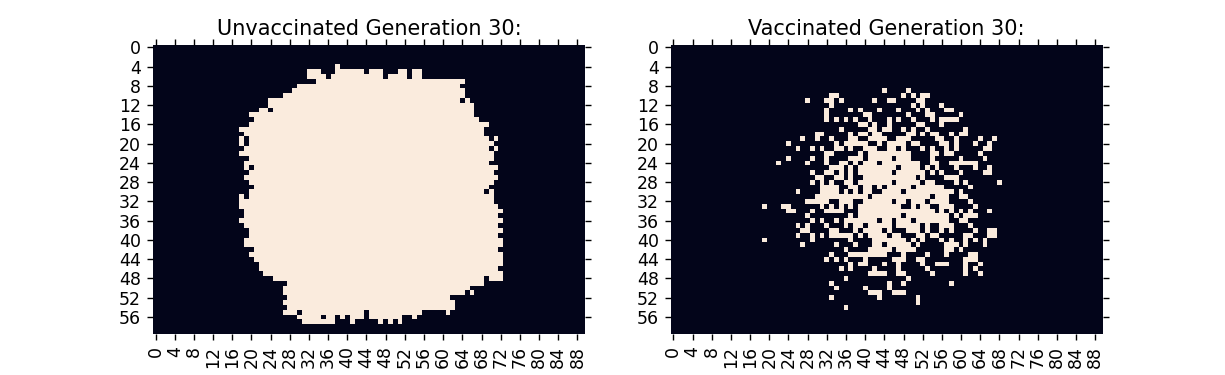

In [95]:
%matplotlib notebook
from scipy.stats import poisson
from scipy.stats import nbinom
from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
import time

class Cell():
    '''
    Describes one cell of the board, which can be infected, healthy; and vaccinated, or unvaccinated
    
    Instance Attributes:
        infected: bool, representing the infection state of the cell
        vaccinated: bool, representing the vaccination state of the cell
    '''
    def __init__(self, vaccinated, infected = False):
        '''
        Inits Cell class.
        
        Args:
            infected: Cell's infection state. False by default on construction.
            vaccinated: Cell's vaccination state. False by default on construction. Can be passed True.
            
        '''
        self.vaccinated = vaccinated
        self.infected = infected


class Board():
    '''
    Creates a board of cell objects, handles generation generation, and returns the display version of the board
    
    Board(row, col) creates a numpy array of cell objects. When next_gen() is called, a poisson distrobution is used
        to determine the amount of neighbors the virus is spread to in that generation for each infected cell. 
        Vaccinated cells have a % (80) chance of being immune to a spread attempt. There is no recovery, this is a 
        simple vaccine efficacy simulation.
    
    Attributes:
        board: Instance of class Board() with row and column arguments
        disp_board: Cell interpretations of board instance, where infected=True is 1, and 0 conversely
        infected_x: Stores the x-coordinate of all infected cells in the last generation
        infected_y: Stores the y-coordinate of all infected cells in the last generation
        queue_x: Stores x-coordinates of infected cells on the current generation to be added to infected_x after
            main loop enumerating infected_x completes
        queue_y: Stores y-coordinates of infected cells on the current generation to be added to infected_x after
            main loop enumerating infected_y completes
            --No pruning of lists; when running multiple generations, longer simulations will generate more lag. Sorry
            
    Instance Attributes:
        row: # of rows
        col: # of columns
            Board & disp_board are defined on init with row and col
    
    '''
    board = None
    disp_board = None
    infected_x = []
    infected_y = []
    queue_x = []
    queue_y = []
    
    def __init__(self, row, col, vac):
        '''
        Inits
        '''
        self.row = row
        self.col = col
        self.vac = vac
        self.board = np.ndarray(shape=(self.row, self.col),dtype=np.object)
        self.disp_board = np.zeros(shape=(self.row, self.col))
        for i in range(row):
            for j in range(col):
                self.board[i, j] = Cell(vaccinated = vac)

    def infect_cell(self, x_pos, y_pos):
        try:
            if not self.board[y_pos, x_pos].infected:
                if self.board[y_pos, x_pos].vaccinated:
                    rng = random.randrange(0, 200)  # % odds of immunity, since there's no disinfection I have to make it high
                    if rng < 199:
                        None
                    else:
                        self.board[y_pos, x_pos].infected = True
                        self.disp_board[y_pos, x_pos] = 1
                        self.queue_x.append(x_pos)
                        self.queue_y.append(y_pos)
                else:
                    self.board[y_pos, x_pos].infected = True
                    self.disp_board[y_pos, x_pos] = 1
                    self.queue_x.append(x_pos)
                    self.queue_y.append(y_pos)
            else:
                None
        except ValueError:
            None

    def next_gen(self):
        rng = random.randrange(0, 100)
        adjacency = np.array([(i,j) for i in (-1,0,1) for j in (-1,0,1) if not (i == j == 0)])  # thanks fortran on stackexchange
        for count, inf_x in enumerate(self.infected_x):
            nb_in = 0 # neighbors infected
            inf_y = self.infected_y[count]
            if self.board[0, 0].vaccinated:
                for ele in spread_mat_vac: # decides how many neighbors to infect.
                    if rng > ele:
                        nb_in += 1
                    else:
                        None
            else:
                for ele in spread_mat_un:
                    if rng > ele:
                        nb_in += 1
                    else:
                        None
            if inf_x == 89 or inf_y == 59 or inf_x == 0 or inf_y == 0:
                None
            else:
                bool_infected = np.array([self.board[inf_y+adjacency[i][0], inf_x+adjacency[i][1]].infected for i in range(8)])
                index = 0
                rand_ad = np.random.permutation(adjacency)
                for dx, dy in rand_ad:
                    if nb_in == 0:
                        break
                    if not bool_infected[index]:
                        self.infect_cell(inf_x+dx, inf_y+dy)
                        nb_in -= 1
                    index += 1
                    if index == 8:
                        break
        self.infected_x = self.infected_x + self.queue_x
        self.infected_y = self.infected_y + self.queue_y
        return self.disp_board

    def seed(self, x_pos, y_pos):
        self.board[y_pos, x_pos].vaccinated = False
        cell_board.infect_cell(45,30)
        
    def title_info(self):
        if self.board[0, 0].vaccinated:
            return 'Vaccinated'
        else:
            return 'Unvaccinated'


def prob_mat_construct():
    r_naught_un = 4  # avg infections per attempt
    r_naught_vac = 1
    temp_spread_mat_un = [round(ele*100,0) for ele in poisson.pmf([0,1,2,3,4,5,6,7,8], r_naught_un)]
    spread_mat_un = []  # probibility matrix
    cur_sum_un = 0
    temp_spread_mat_vac = [round(ele*100,0) for ele in poisson.pmf([0,1,2,3,4,5,6,7,8], r_naught_vac)]
    spread_mat_vac = []
    cur_sum_vac = 0
    
    for count, ele in enumerate(temp_spread_mat_un):
        spread_mat_un.append(int(ele + cur_sum_un))
        cur_sum_un = spread_mat_un[count]
    for count, ele in enumerate(temp_spread_mat_vac):
        spread_mat_vac.append(int(ele + cur_sum_vac))
        cur_sum_vac = spread_mat_vac[count]        
    return spread_mat_un, spread_mat_vac


def animate(i):
    ax1.cla()
    ax2.cla()
    ax1.set_title(f'{cell_board.title_info()} Generation {i}:')
    ax2.set_title(f'{cell_board_vac.title_info()} Generation {i}:')
    data = cell_board.next_gen()
    data2 = cell_board_vac.next_gen()
    sns.heatmap(data,
                ax = ax1,
                cbar = False,
                vmin = 0,
                vmax = 1)
    sns.heatmap(data2,
            ax = ax2,
            cbar = False,
            vmin = 0,
            vmax = 1)
    
spread_mat_un, spread_mat_vac = prob_mat_construct()
cell_board_vac, cell_board, fig, ax1, ax2, anim = None, None, None, None, None, None


def main():
    global cell_board, cell_board_vac, fig, ax1, ax2, anim
    cell_board = Board(60,90, vac = False)
    cell_board_vac = Board(60,90, vac = True)
    cell_board.seed(45,30)
    cell_board_vac.seed(45,30)
    
    grid_kws = {'width_ratios': (0.9, 0.9), 'wspace': 0.2}
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw = grid_kws, figsize = (9.8, 3))
    
    anim = FuncAnimation(fig = fig, func = animate, frames = 31, interval = 200, blit = False, repeat = False)
    plt.show()
    
    
    
if __name__ == '__main__':
    main()